In [332]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from collections import defaultdict
import torch.nn as nn
import torch.nn.functional as F
from modules import acgan, hacgan, shacgan, shacgan_weak, shacgan_weaker, shacgan_weaker_cc, shacgan_weak_cc_no_linear_zfc
import utils
import json
from collections import OrderedDict
from nilearn.input_data import NiftiMasker
import nilearn.masking as masking
from nilearn.image import load_img, resample_img, math_img, crop_img, resample_to_img
from nilearn import plotting
import nibabel
from nilearn.datasets import load_mni152_template, load_mni152_brain_mask
full_mask = load_mni152_brain_mask()
downsampled_mask = resample_img(full_mask, target_shape=(30, 36, 30), target_affine=utils.downsampled_affine, interpolation='nearest')
import dataset, hdataset
import pandas as pd
import torch.optim as optim
import time
from exploration import msssim
def plotvol(vol):
    plotting.plot_img(
        nibabel.Nifti1Image( # "img1 * img2", img1=nibabel.Nifti1Image(
            vol.detach().numpy(), np.eye(4)
        ),
#         bg_img=False,
        black_bg=False,
    )


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [147]:
# Define checkpoint
all_df = pd.read_csv("/data/neurovault/resampled_dataframe.csv")
all_studies = ['archi', 'hcp', 'la5c', 'camcan', 'brainomics']
trn, tst, train_loaders, test_loaders, mapping = hdataset.get_dataloaders(all_studies, 32, num_workers=0, debug=False)
base_dir_ = "outputs"
model_type_ = "hacgan_dragan"
run_id_ = "w2shccnlz"  # "weakercc_shac_all"
def get_checkpoint(bidx, run_id=run_id_, model_type=model_type_, base_dir=base_dir_):
    return torch.load(os.path.join(base_dir, model_type, run_id, "models", "model_batch{}.checkpoint".format(bidx)))

In [264]:
chk = get_checkpoint(31999)
with open(os.path.join(base_dir_, model_type_, run_id_, "information.json")) as f:
    args = json.load(f)['args']
args = utils.DotDict(args)
args.mapping['si2ti'] = {int(k): v for k, v in args.mapping['si2ti'].items()}
args.mapping['ti2ci'] = {int(k): v for k, v in args.mapping['ti2ci'].items()}

In [265]:
mapping = args.mapping
si2ti_mask = np.zeros((len(mapping['s2i']), len(mapping['t2i'])), dtype=np.float32)
mapping['si2ti'][0]

[0, 1, 2, 3]

In [266]:
model = shacgan_weak_cc_no_linear_zfc.HACGAN(args, chk['model'])
model = model.cpu()
model.args.cuda = False
model = model.eval()

In [267]:
print(args.mapping['s2i'])
print(args.mapping['si2ti'][2])
args.mapping['ti2ci'][5]

{'brainomics': 1, 'camcan': 2, 'la5c': 4, 'archi': 0, 'hcp': 3}
[4, 5]


[51, 52, 53]

[[1.         0.99993426 0.99987584 ... 0.9998869  0.99983126 0.9998535 ]
 [0.99993426 1.         0.9998501  ... 0.9999018  0.9997589  0.9998616 ]
 [0.99987584 0.9998501  1.         ... 0.99984455 0.99987954 0.99987304]
 ...
 [0.9998869  0.9999018  0.99984455 ... 1.         0.9997174  0.99993175]
 [0.99983126 0.9997589  0.99987954 ... 0.9997174  1.         0.9997332 ]
 [0.9998535  0.9998616  0.99987304 ... 0.99993175 0.9997332  1.        ]]


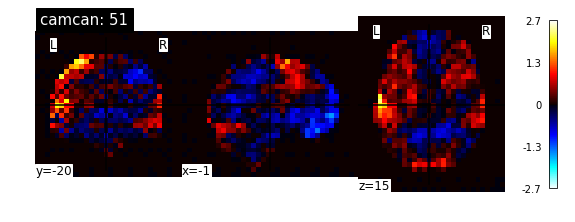

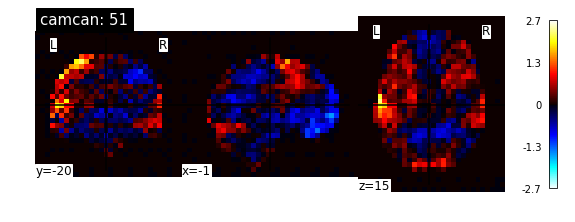

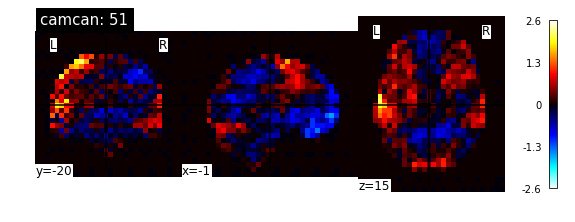

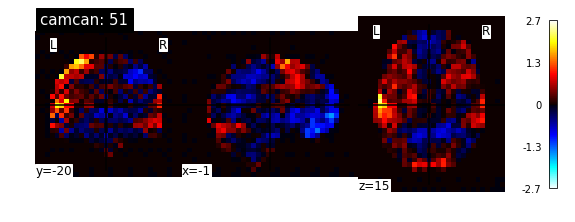

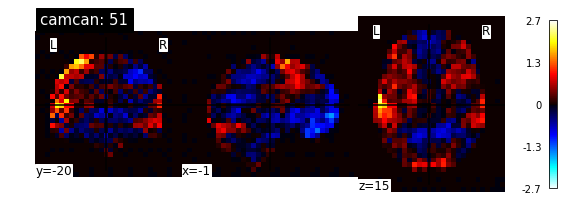

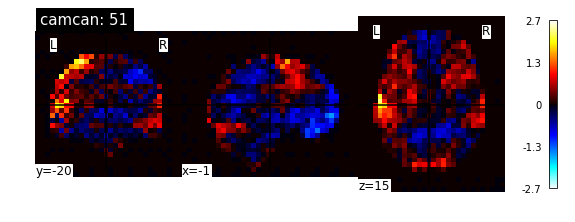

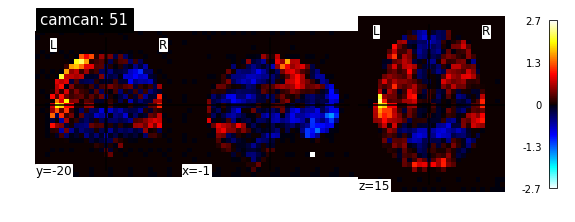

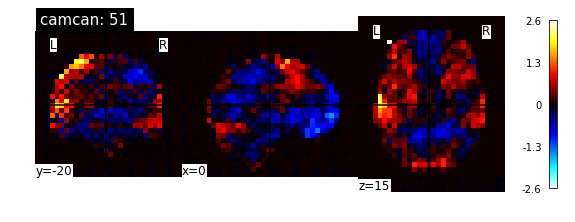

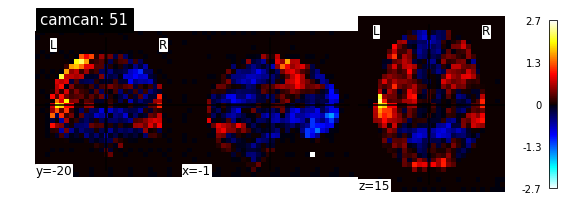

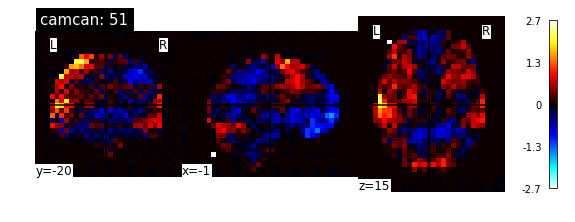

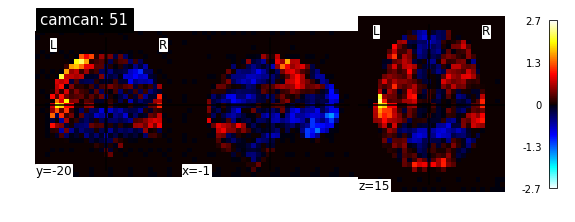

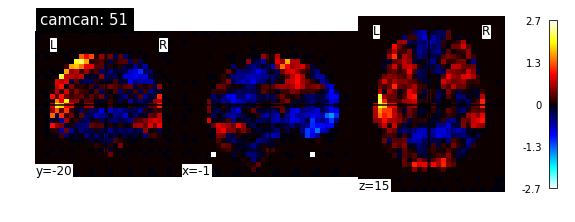

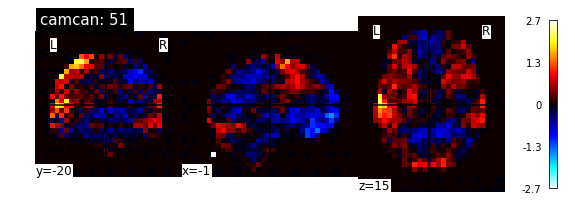

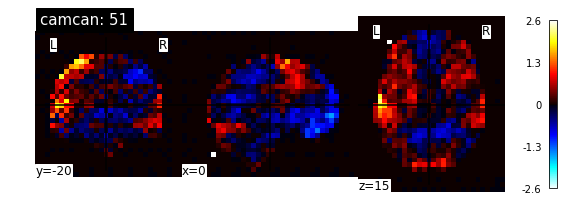

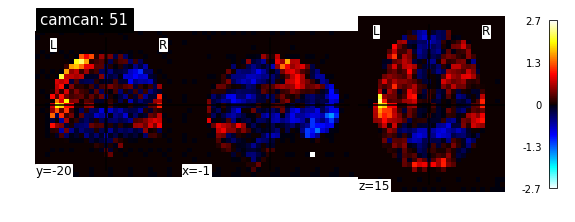

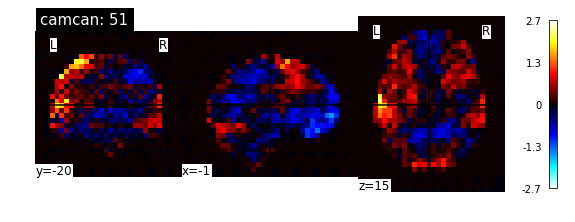

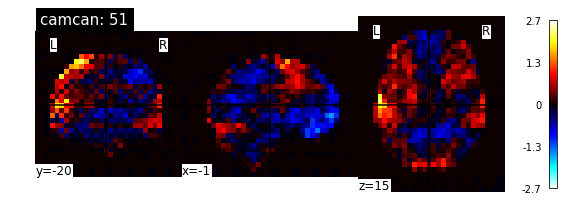

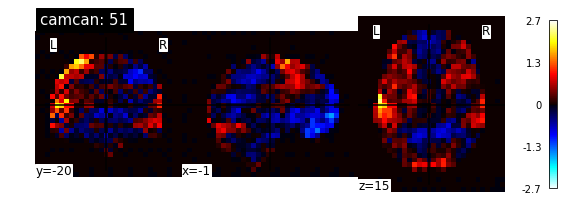

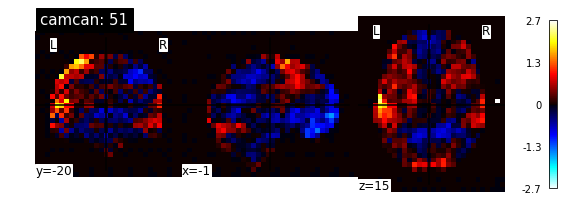

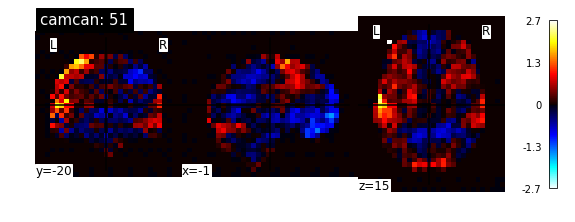

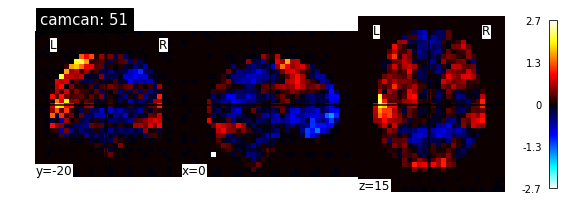

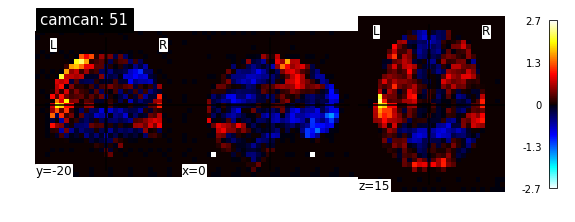

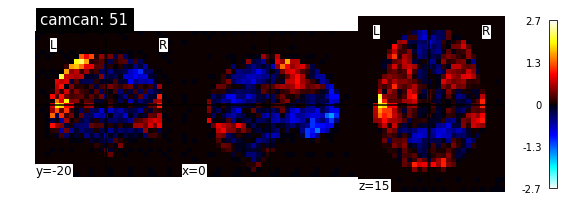

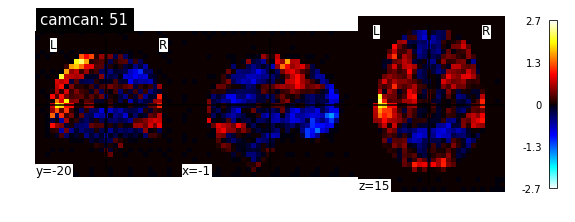

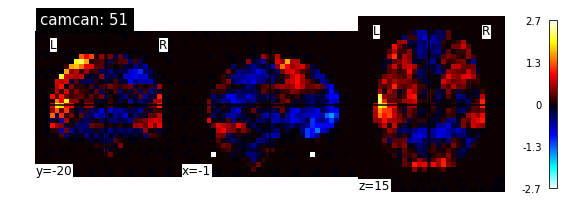

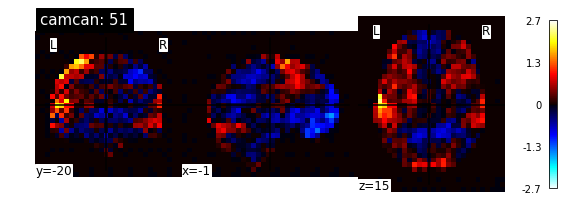

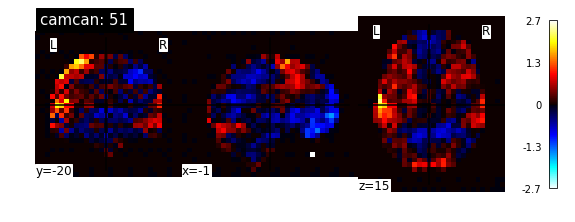

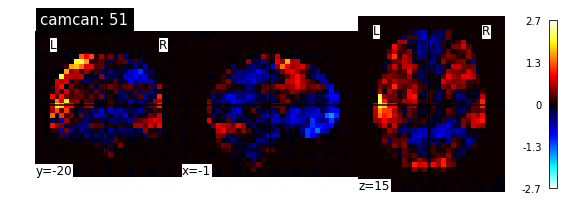

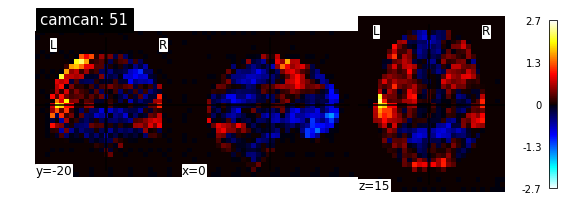

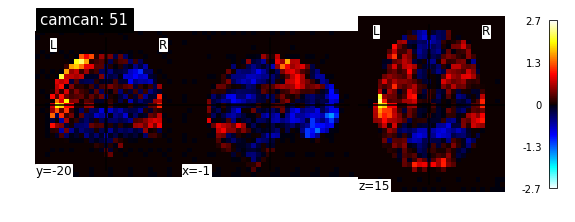

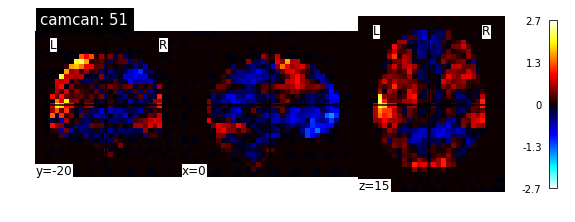

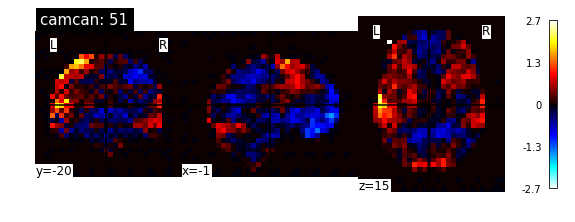

In [280]:
study = 'camcan'
n = 32
study_ids = [args.mapping['s2i'][study]] * n
contrast_ids = [51] * n
task_ids = [4] * n
st = torch.tensor(study_ids, device='cpu')
tt = torch.tensor(task_ids, device='cpu')
ct = torch.tensor(contrast_ids, device='cpu')
msssims = np.zeros((len(contrast_ids), len(contrast_ids)), dtype=np.float32)
msssim_fn = msssim.MSSSIM(channel=1)
with torch.no_grad():
    z = torch.randn(n, model.LATENT_SIZE, device='cpu')
    gz = model.generator(z, st, tt, ct)
    for i in range(len(contrast_ids)):
        for j in range(len(contrast_ids)):
            msssims[i, j] = msssim_fn(gz[i].unsqueeze(0).unsqueeze(0), gz[j].unsqueeze(0).unsqueeze(0)).item()

for i in range(gz.shape[0]):
    plotting.plot_stat_map(
        math_img("img1", img1=nibabel.Nifti1Image( # "img1 * img2", img1=nibabel.Nifti1Image(
            trn[study].mu + trn[study].std * gz[i].numpy(), utils.downsampled_affine
        ), img2=downsampled_mask),
        black_bg=False,
        title="{}: {}".format(study, contrast_ids[i])
    )
print(msssims)

In [30]:
batch = np.stack([trn['archi'][i][0] for i in [np.random.choice(list(range(1000))) for k in range(32)]])

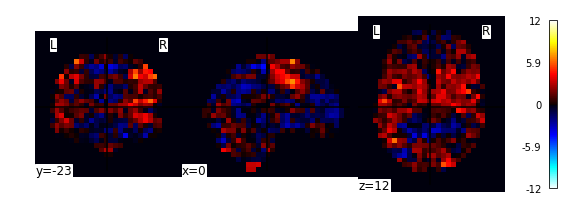

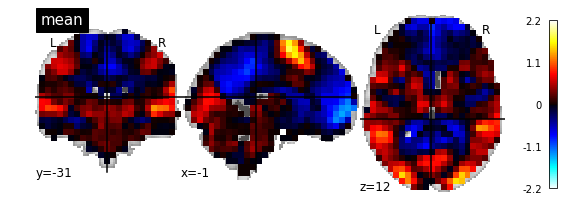

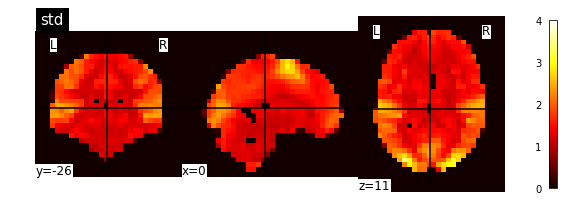

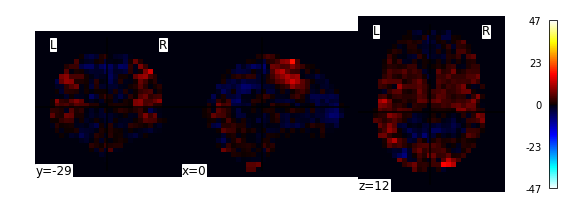

In [42]:
for i in range(1):
    img = nibabel.Nifti1Image(
            batch[i], utils.downsampled_affine
        )
    plotting.plot_stat_map(
        math_img("img1", img1=img, img2=downsampled_mask),
        black_bg=False,
    )
    img = nibabel.Nifti1Image(
            trn['archi'].mu, utils.downsampled_affine
        )
    plotting.plot_stat_map(
        math_img("img1", img1=img, img2=downsampled_mask),
        black_bg=False,
        title="mean",
    )
    img = nibabel.Nifti1Image(
            trn['archi'].std, utils.downsampled_affine
        )
    plotting.plot_stat_map(
        math_img("img1", img1=img, img2=downsampled_mask),
        black_bg=False,
        title="std",
    )
    img = nibabel.Nifti1Image(
            trn['archi'].mu + trn['archi'].std * batch[i], utils.downsampled_affine
        )
    plotting.plot_stat_map(
        math_img("img1", img1=img, img2=downsampled_mask),
        black_bg=False,
    )
    

In [88]:
args.mapping['s2i']

{'archi': 0, 'brainomics': 1, 'camcan': 2, 'hcp': 3, 'la5c': 4}

In [89]:
args.mapping['i2t']

{'0': 'social',
 '1': 'parietal',
 '10': 'GAMBLING',
 '11': 'EMOTION',
 '12': 'LANGUAGE',
 '13': 'scap',
 '14': 'taskswitch',
 '15': 'stopsignal',
 '16': 'bart',
 '17': 'bht',
 '18': 'pamret',
 '19': 'pamenc',
 '2': 'localizer',
 '3': 'emotional',
 '4': 'audio-video',
 '5': 'AV-freq',
 '6': 'MOTOR',
 '7': 'WM',
 '8': 'SOCIAL',
 '9': 'RELATIONAL'}

In [91]:
args.mapping['si2ti'][2]

[4, 5]

In [156]:
z = torch.randn(32, model.LATENT_SIZE, device='cpu')
zout = model.generator.zfc(z)
print(z.std(dim=0).mean())
print(zout.std(dim=0).mean())

tensor(0.9968)
tensor(0.9968)


In [155]:
model.generator.contrast_embedding.weight[49]

tensor([ 0.3168,  0.3127, -0.1173,  0.5087,  0.1677,  0.3393, -1.3882,  0.4231,
         0.5483, -0.2724,  0.1319,  0.9430, -0.1698, -0.0043,  0.1117, -0.5156])

In [154]:
model.generator.task_embedding.weight[4]

tensor([ 1.7833,  1.0266, -1.4532, -0.0447, -0.2100, -0.3187, -0.4257,  0.8138,
        -0.9987,  0.0765,  1.4345, -0.2765, -0.9673, -0.7252,  1.1057, -0.5743])

In [153]:
model.generator.study_embedding.weight[args.mapping['s2i'][study]]

tensor([-0.6538, -0.3612,  0.9516,  0.4126,  0.1196,  1.0098, -1.3234,  0.0498,
        -0.5592, -0.9124,  0.4060, -1.6934, -1.2564,  0.6014, -0.2951, -0.5141])

In [197]:
def invert_hacgan_g(model, x, s, t, c, inv_lr=1e-3, inv_wd=0.0, inv_iters=100, use_cuda=False):
    device = 'cuda' if use_cuda else 'cpu'
    x = x.to(device)
    s = s.to(device)
    t = t.to(device)
    c = c.to(device)
    if use_cuda:
        model = model.cuda()
    z = torch.randn((x.shape[0], model.LATENT_SIZE), requires_grad=True, device=device, dtype=torch.float)
    params = [z]
    optimizer = optim.Adam(
        params,
        lr=inv_lr,
        betas=(0.5, 0.9),
        weight_decay=inv_wd,
    )
    orig_loss = None
    start = time.time()
    for i in range(inv_iters):
        Gz = model.generator(z, s, t, c)
        loss = F.mse_loss(Gz, x)
        if orig_loss is None:
            orig_loss = loss.item()
        optimizer.zero_grad()
        loss.backward()
        norm = 0.0
        for p in params:
            print("[{}] ||{}|| = {}".format(i, p.detach().norm()))
        
        optimizer.step()
    print("Got a drop from {}->{} in {}s".format(orig_loss, loss.item(), time.time() - start))
    return z


In [198]:
dbgx, dbgs, dbgt, dbgc = next(iter(test_loaders['archi']))

In [199]:
dbgz = invert_hacgan_g(model, dbgx, dbgs, dbgt, dbgc, use_cuda=True, inv_iters=10)

[0] ||params|| = 63.874481201171875
[1] ||params|| = 63.87493133544922
[2] ||params|| = 63.8753776550293
[3] ||params|| = 63.8758430480957
[4] ||params|| = 63.876338958740234
[5] ||params|| = 63.87685775756836
[6] ||params|| = 63.877410888671875
[7] ||params|| = 63.87800216674805
[8] ||params|| = 63.87862777709961
[9] ||params|| = 63.87929153442383
Got a drop from 0.26946303248405457->0.26945728063583374 in 0.5350518226623535s


In [196]:
t = 0.02 * torch.randn(4, 10, 20)
t.norm()

tensor(0.5590)

In [203]:
dbgx.std(dim=0)

tensor(0.2223)

In [209]:
(downsampled_mask.get_data()).size

32400

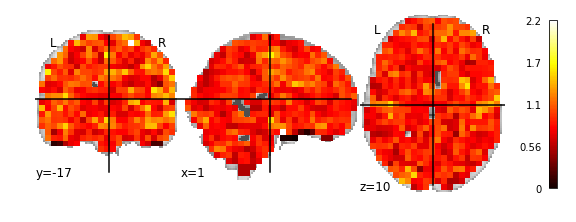

In [219]:
dbgx_std_img = nibabel.Nifti1Image(dbgx.std(dim=0).detach().cpu().numpy(), downsampled_mask.affine)
plotting.plot_stat_map(
    dbgx_std_img,
    black_bg=False,
)


In [225]:
masked_std = torch.masked_select(dbgx.std(dim=0), torch.from_numpy(downsampled_mask.get_data().astype(np.uint8)))

In [230]:
masked_std.min()

tensor(0.)

In [254]:
trn_c = {}
tst_c = {}
for k, v in trn.items():
    trn_c[k] = set(v.df.contrast.unique().tolist())
for k, v in tst.items():
    tst_c[k] = set(v.df.contrast.unique().tolist())

In [256]:
for k in trn_c.keys():
    print("intersection/trn/tst: {}/{}/{}".format(len(trn_c[k].intersection(tst_c[k])), len(trn_c[k]), len(tst_c[k])))

intersection/trn/tst: 19/19/19
intersection/trn/tst: 30/30/30
intersection/trn/tst: 24/24/24
intersection/trn/tst: 23/23/23
intersection/trn/tst: 5/5/5


# Step through Generator

In [276]:
# Step through generator
gen = model.generator
gen

Generator(
  (zfc): Sequential(
    (0): Dropout(p=0.5)
  )
  (study_embedding): Embedding(5, 16)
  (task_embedding): Embedding(20, 16)
  (contrast_embedding): Embedding(101, 16)
  (fcs): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Dropout(p=0.5)
    )
    (1): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): Dropout(p=0.5)
    )
    (2): Sequential(
      (0): Linear(in_features=48, out_features=16, bias=True)
      (1): Dropout(p=0.5)
    )
    (3): Sequential(
      (0): Linear(in_features=48, out_features=16, bias=True)
      (1): Dropout(p=0.5)
    )
  )
  (upsample0): CCT3D(
    (convt): ConvTranspose3d(147, 128, kernel_size=(3, 4, 3), stride=(2, 2, 2), padding=(0, 1, 0))
  )
  (activation0): Sequential(
    (0): LeakyReLU(negative_slope=0.2)
    (1): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Dropout(p=0.5)
  )
  (upsample1): CCT3D(
   

In [281]:
z.shape

torch.Size([32, 128])

In [282]:
se = gen.study_embedding(st)
te = gen.task_embedding(tt)
ce = gen.contrast_embedding(ct)
contents = [
    se,
    torch.cat([se, te], dim=1),  # se + te,
    torch.cat([se, te, ce], dim=1),  # se + te + ce
]
contents.append(contents[-1])
contents = [gen.fcs[i](content) for i, content in enumerate(contents)]


In [298]:
(contents[3] - contents[2]).mean(0)

tensor([-0.5254,  0.6564, -0.5504, -0.3236, -0.6327, -0.6241, -0.0382,  0.1660,
         0.9187, -1.0730, -0.2317, -1.6010,  0.5399, -0.2251,  0.0700, -0.8837],
       grad_fn=<MeanBackward0>)

In [299]:
cur_z = gen.zfc(z).unsqueeze(2).unsqueeze(2).unsqueeze(2).expand(z.shape[0], z.shape[1], 1, 2, 1)

In [320]:
cur_z.shape

torch.Size([32, 128, 1, 2, 1])

In [304]:
content = contents[0].unsqueeze(2).unsqueeze(2).unsqueeze(2).expand(z.shape[0], 16, cur_z.shape[2], cur_z.shape[3], cur_z.shape[4])
curz1 = gen.upsample0(torch.cat([cur_z, content], dim=1))

In [315]:
gen.upsample0.convt.weight.std()

tensor(0.0044, grad_fn=<StdBackward0>)

(array([  12.,   76.,  326., 1112., 1880., 2184., 1576.,  758.,  210.,
          58.]),
 array([-3.62582779, -2.94254529, -2.2592628 , -1.57598031, -0.89269781,
        -0.20941532,  0.47386718,  1.15714967,  1.84043217,  2.52371466,
         3.20699716]),
 <a list of 10 Patch objects>)

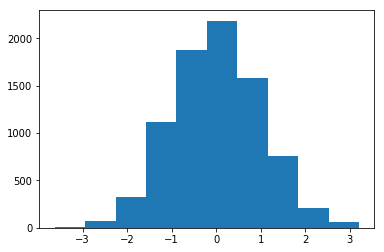

In [321]:
plt.hist(cur_z.detach().contiguous().view(-1).numpy())

(array([3.000e+00, 2.000e+00, 1.200e+01, 4.700e+01, 2.754e+03, 4.000e+02,
        3.300e+01, 5.000e+00, 6.000e+00, 2.000e+00]),
 array([-0.57365024, -0.45504096, -0.33643167, -0.21782238, -0.0992131 ,
         0.01939619,  0.13800547,  0.25661476,  0.37522404,  0.49383333,
         0.61244261]),
 <a list of 10 Patch objects>)

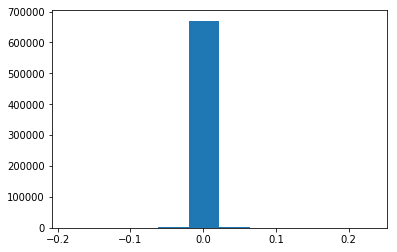

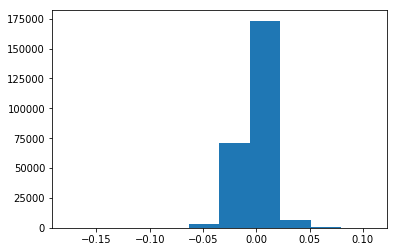

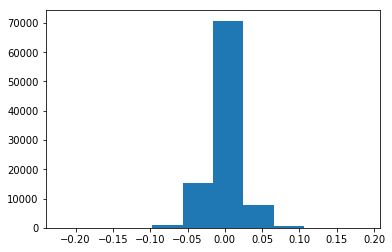

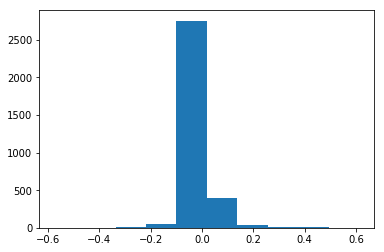

In [323]:
plt.figure()
plt.hist(gen.upsample0.convt.weight.detach().view(-1).numpy())
plt.figure()
plt.hist(gen.upsample1.convt.weight.detach().view(-1).numpy())
plt.figure()
plt.hist(gen.upsample2.convt.weight.detach().view(-1).numpy())
plt.figure()
plt.hist(gen.upsample3.convt.weight.detach().view(-1).numpy())

(array([1.1100e+02, 1.1200e+03, 6.0090e+03, 2.1094e+04, 3.7100e+03,
        3.4100e+02, 1.1000e+01, 1.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([-0.95507634, -0.6409994 , -0.32692246, -0.01284553,  0.30123141,
         0.61530834,  0.92938528,  1.24346222,  1.55753915,  1.87161609,
         2.18569303]),
 <a list of 10 Patch objects>)

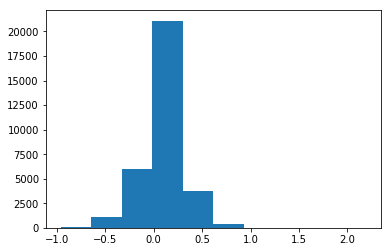

In [318]:
plt.hist(gz[0].detach().view(-1).numpy())

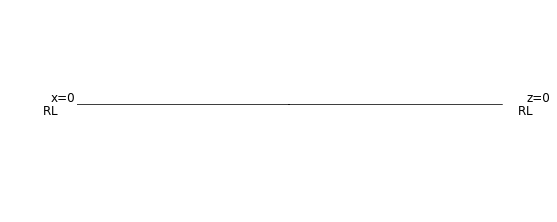

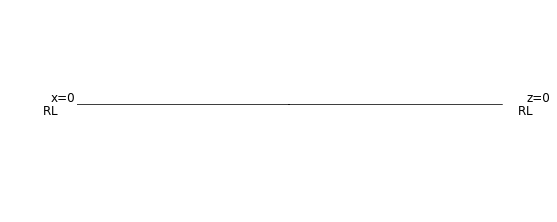

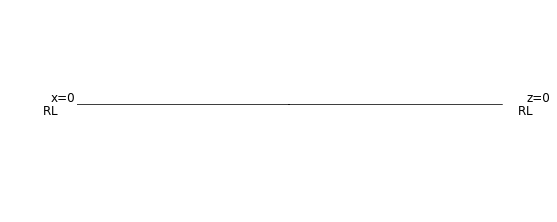

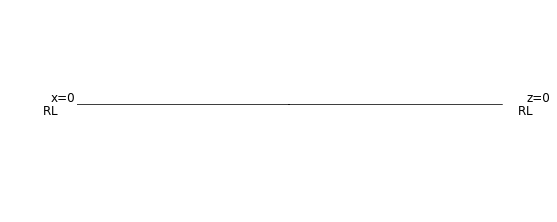

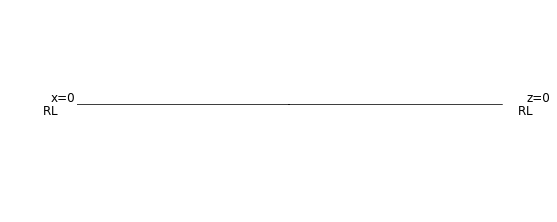

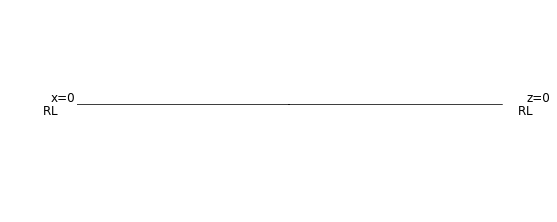

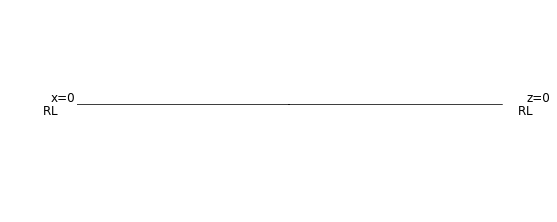

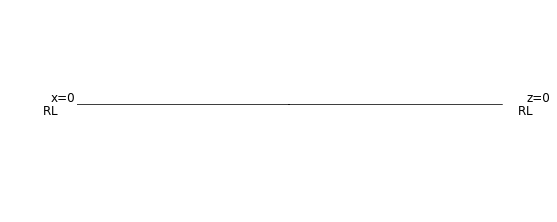

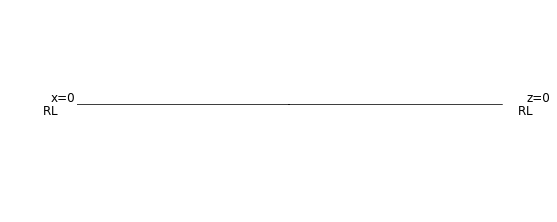

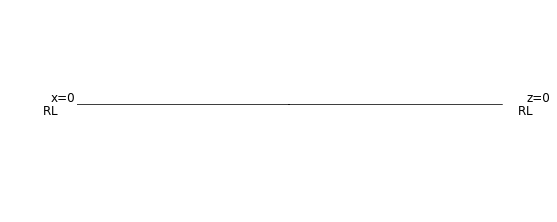

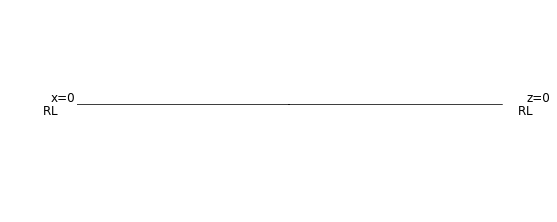

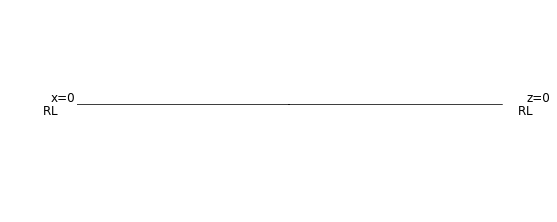

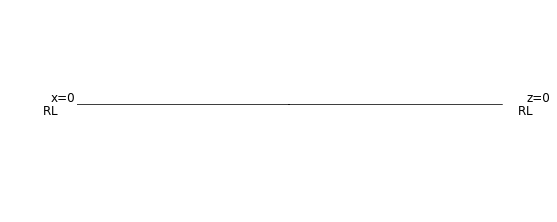

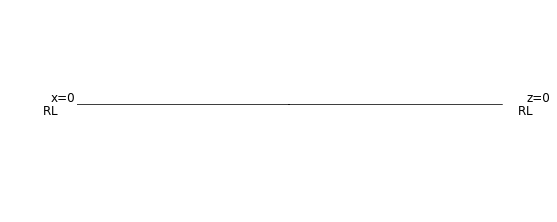

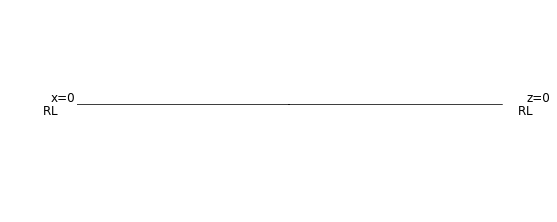

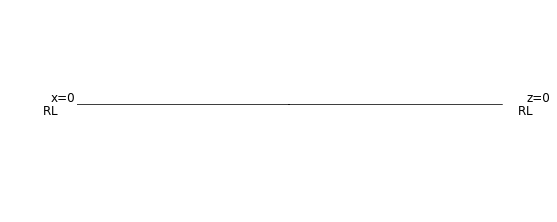

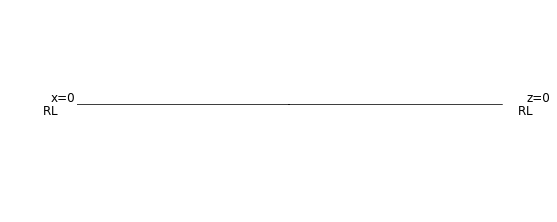

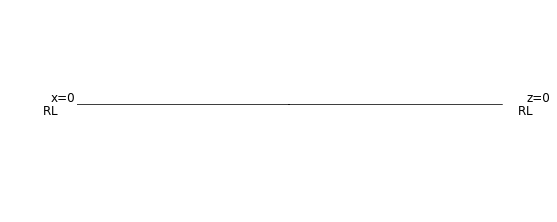

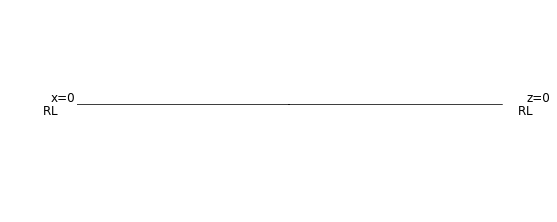

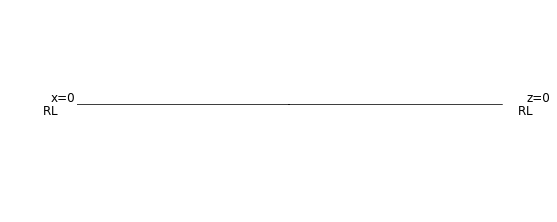

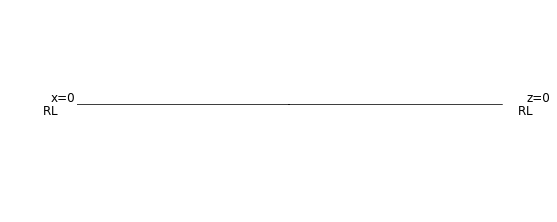

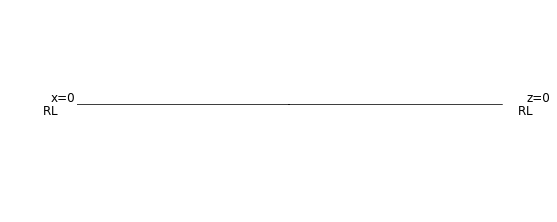

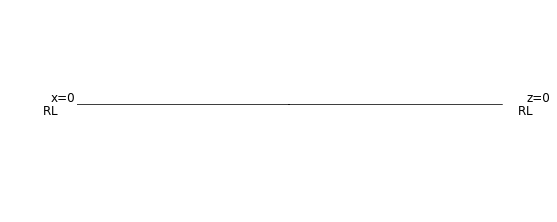

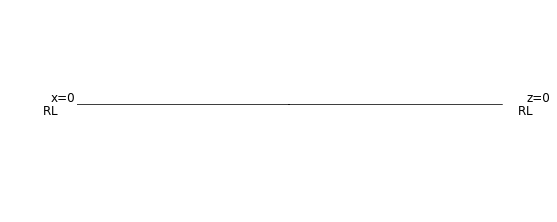

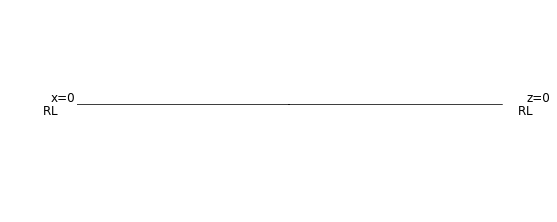

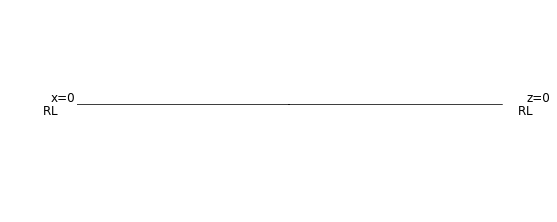

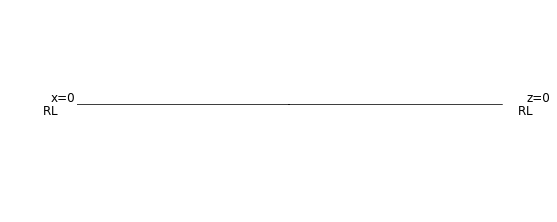

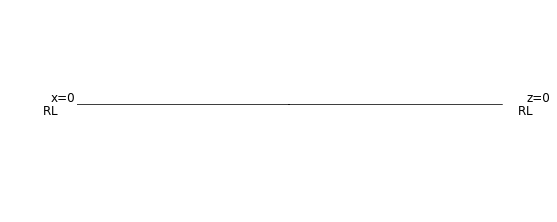

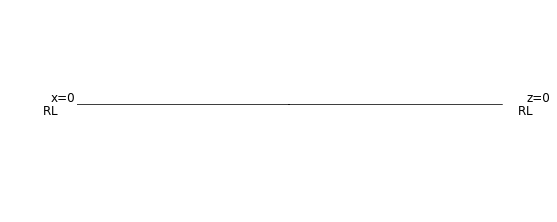

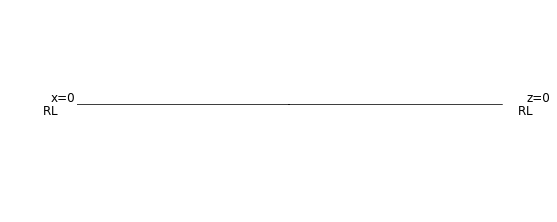

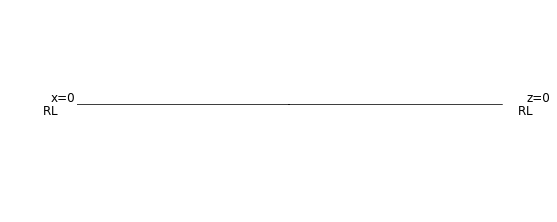

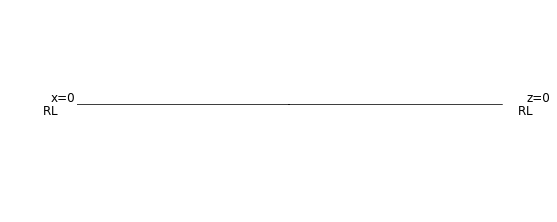

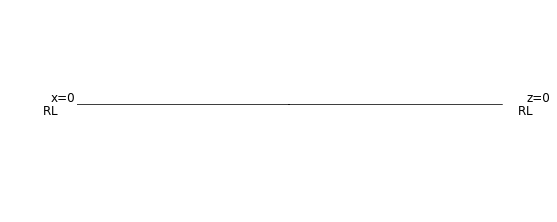

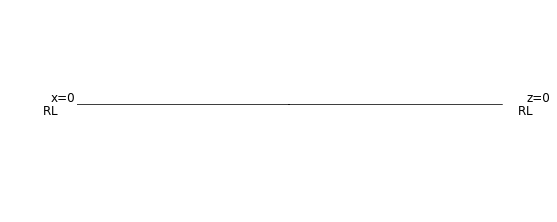

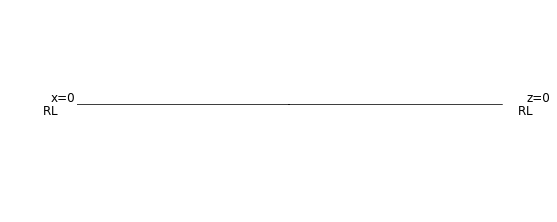

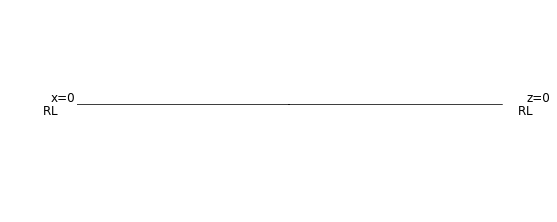

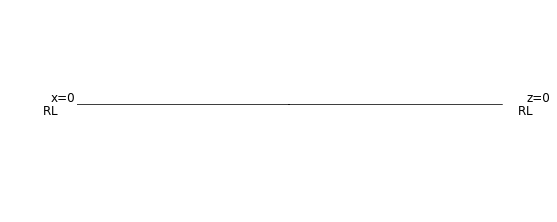

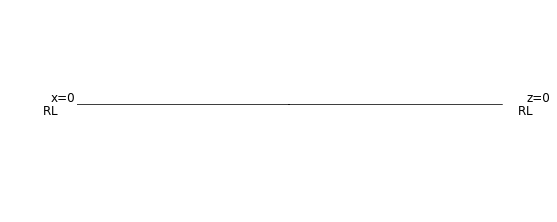

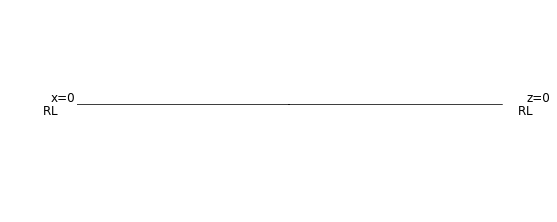

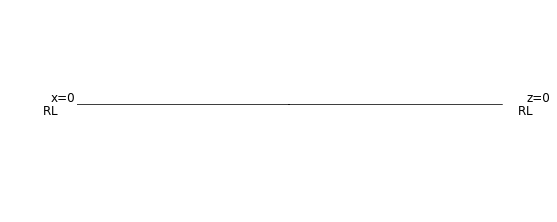

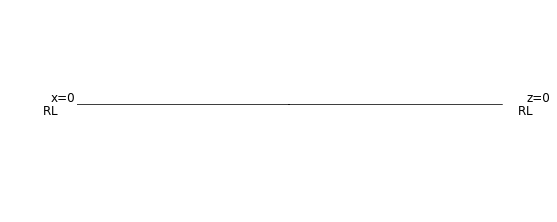

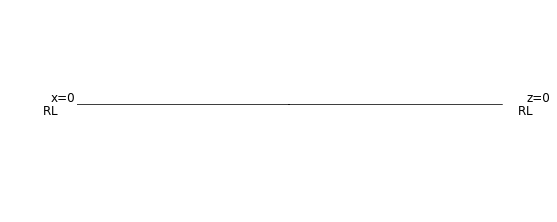

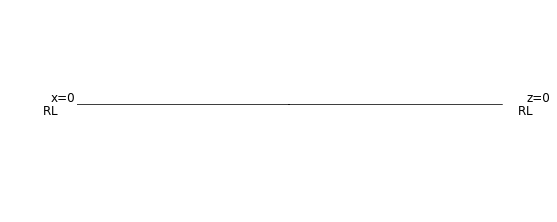

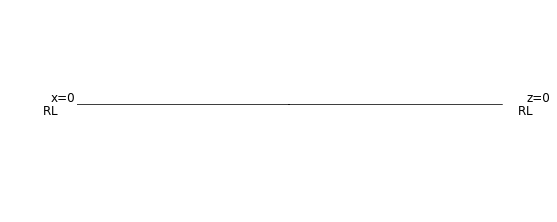

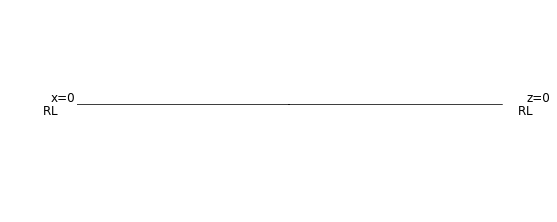

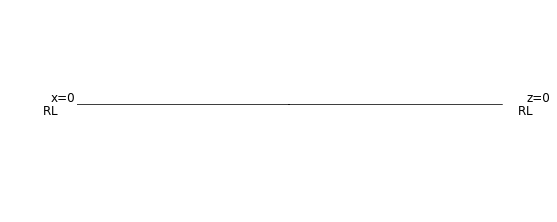

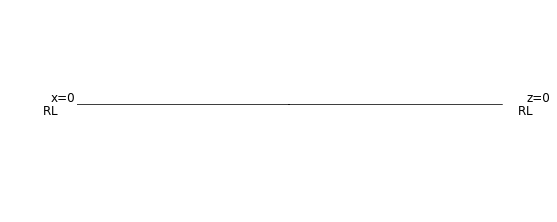

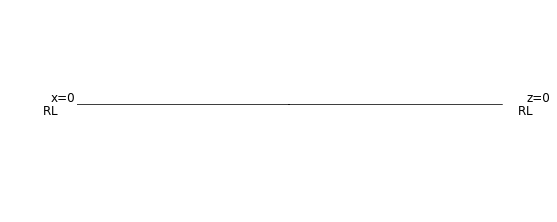

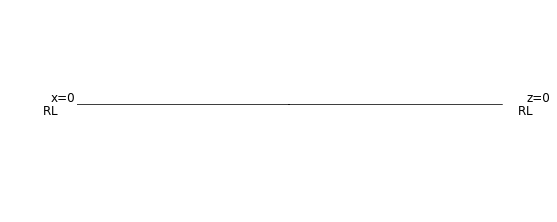

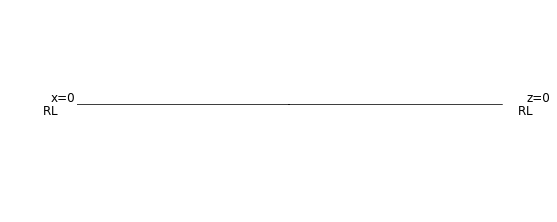

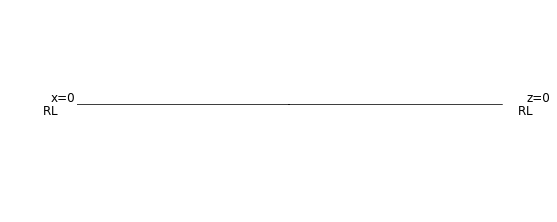

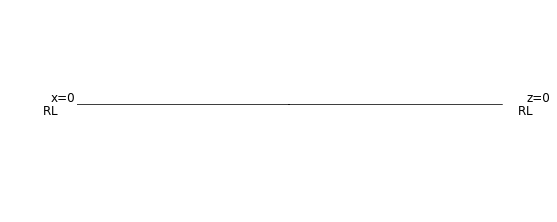

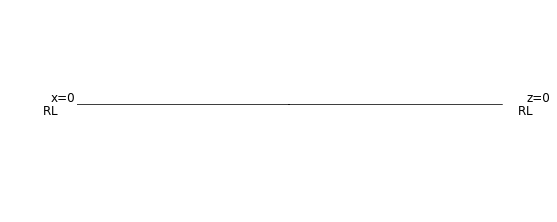

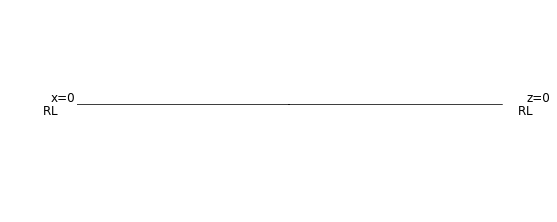

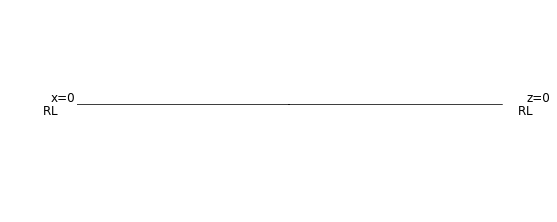

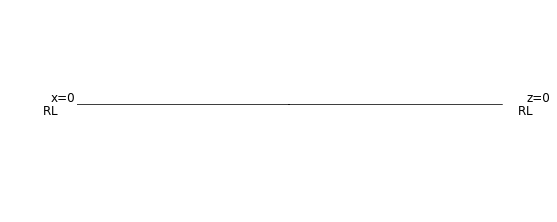

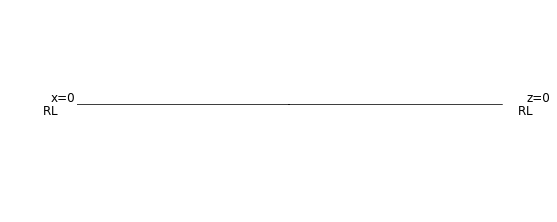

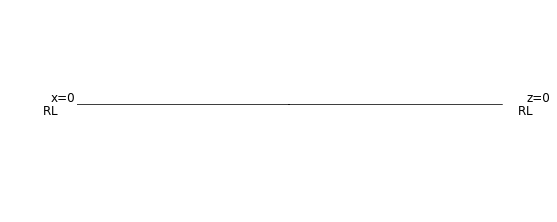

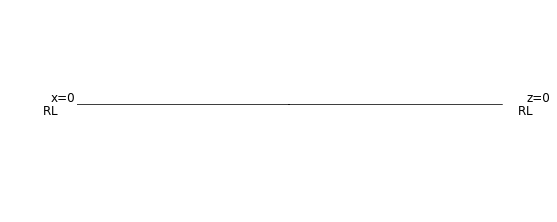

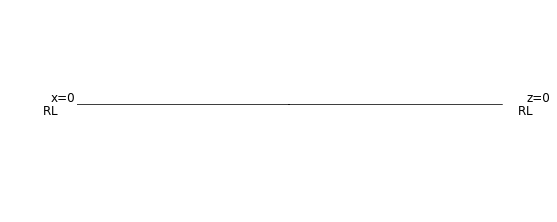

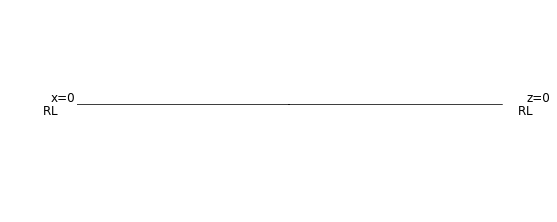

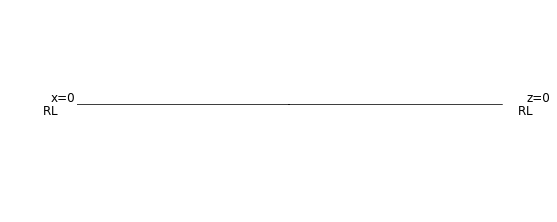

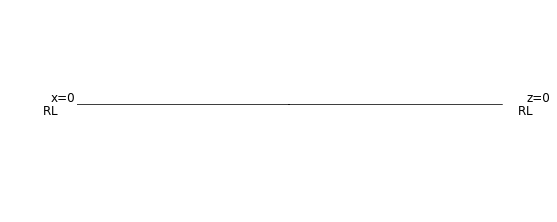

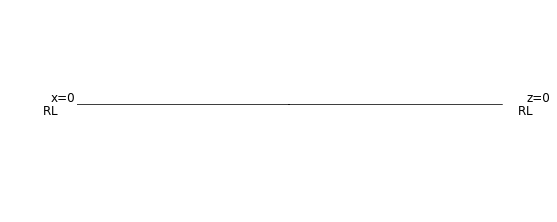

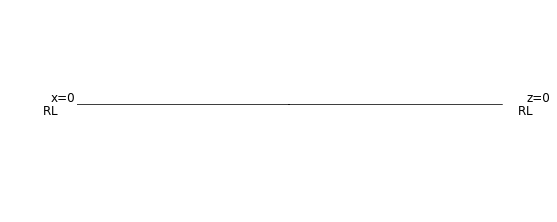

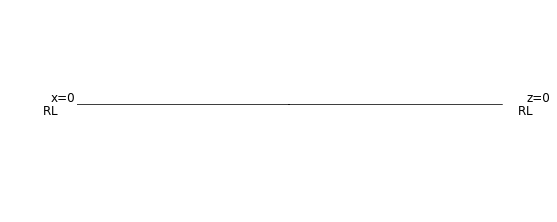

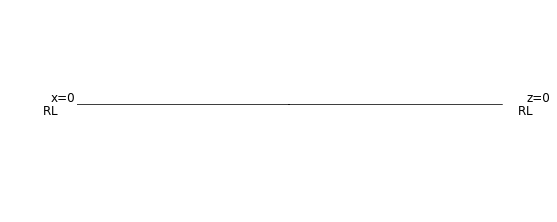

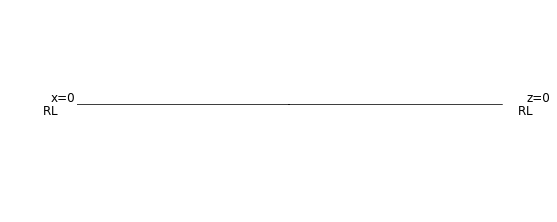

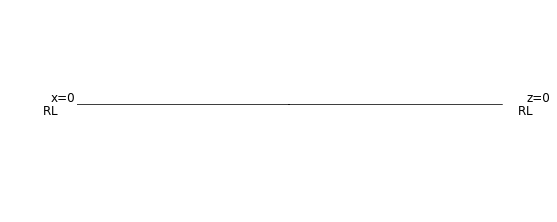

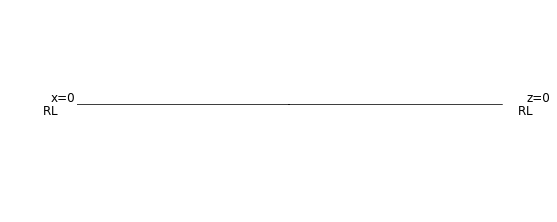

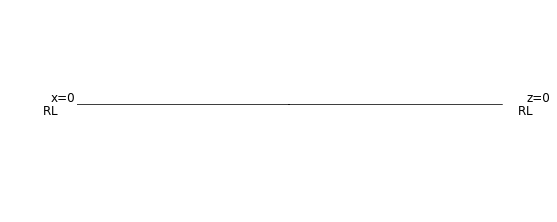

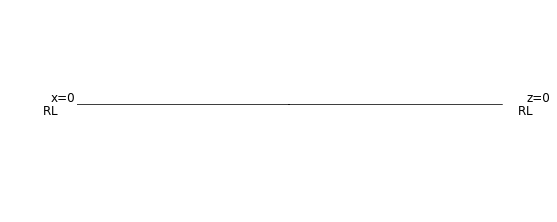

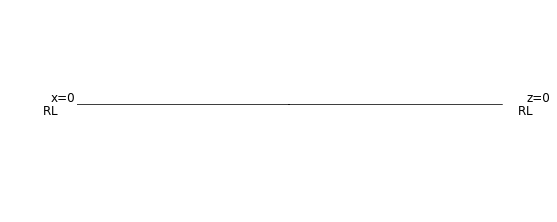

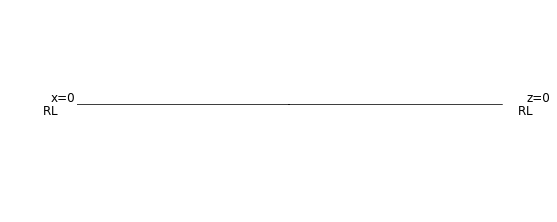

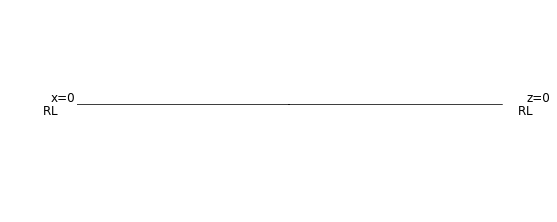

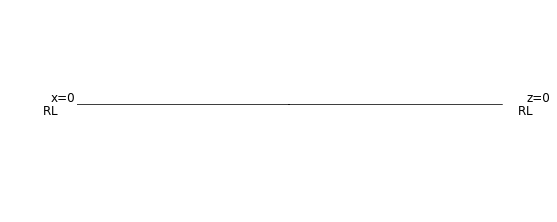

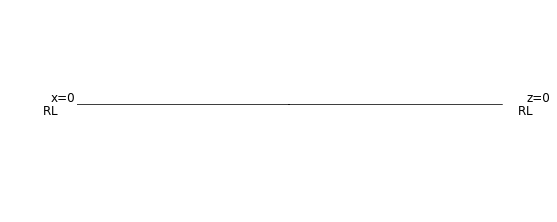

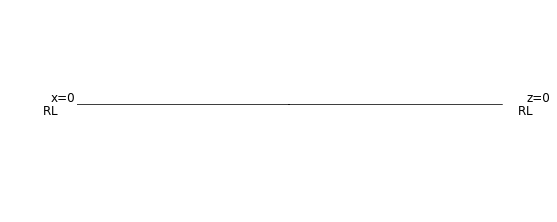

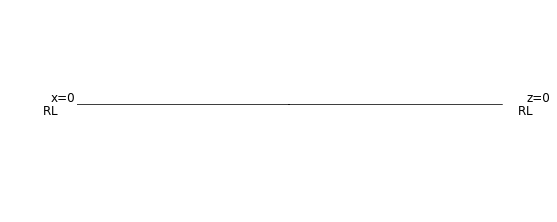

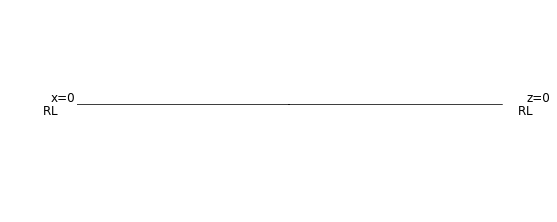

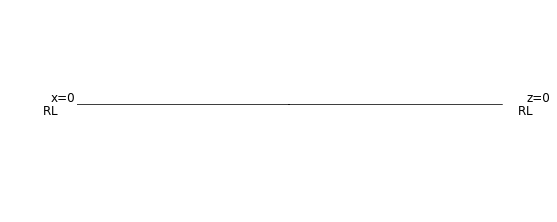

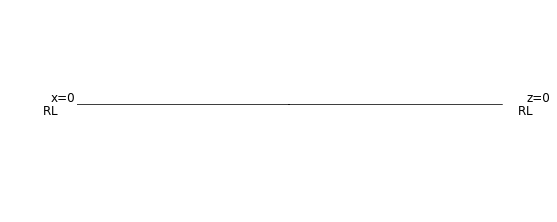

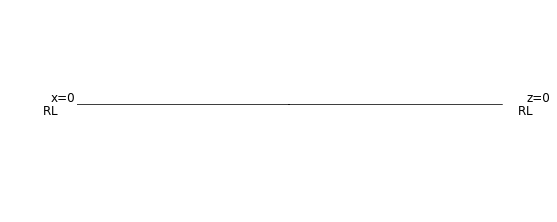

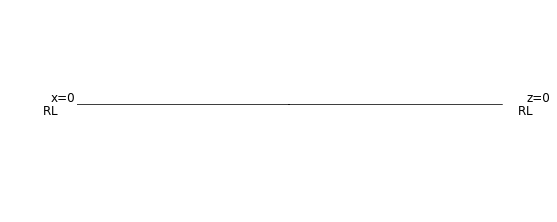

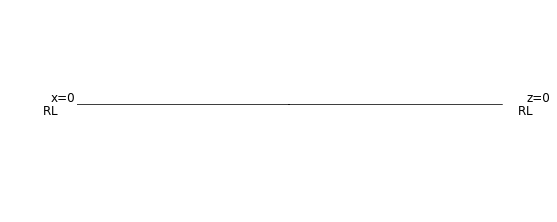

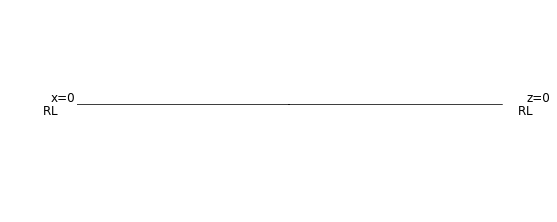

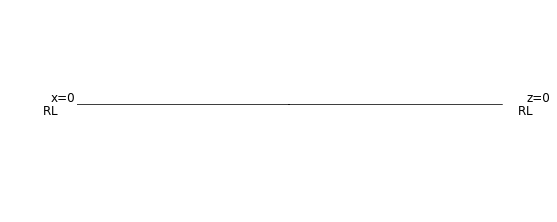

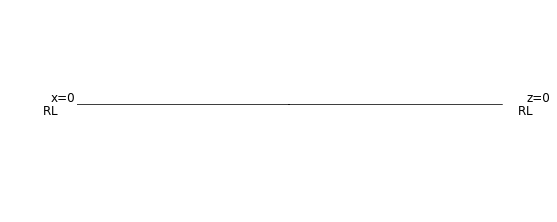

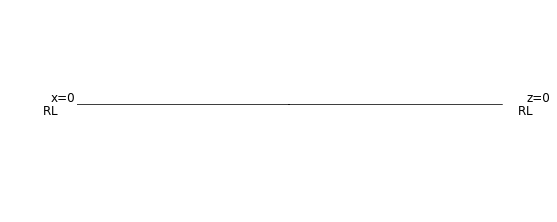

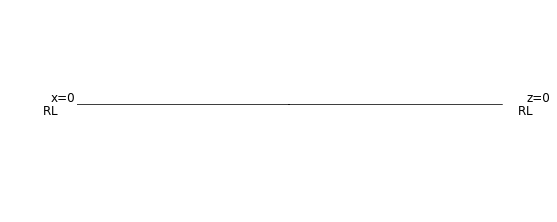

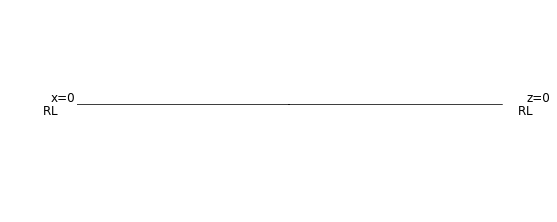

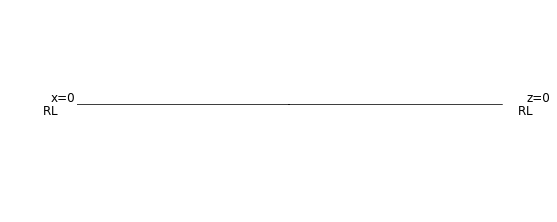

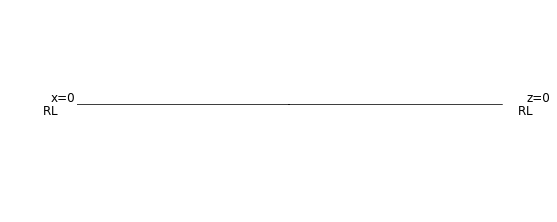

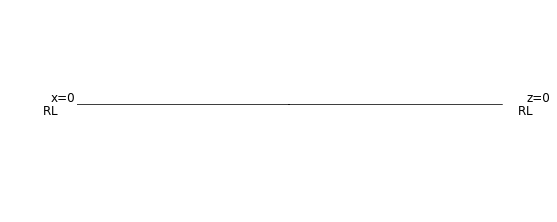

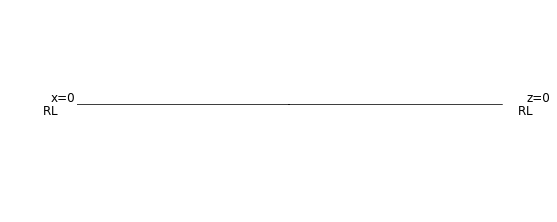

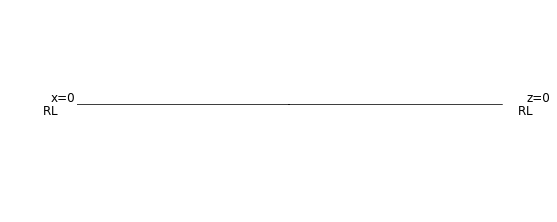

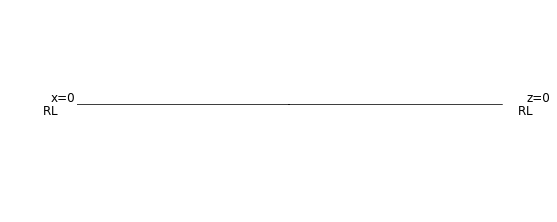

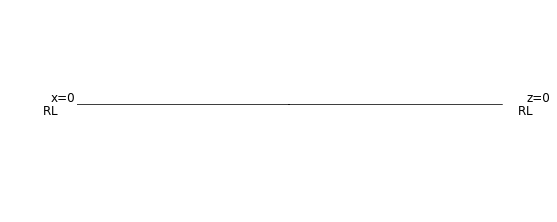

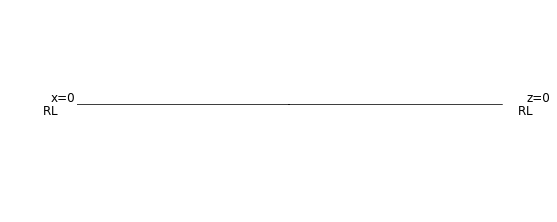

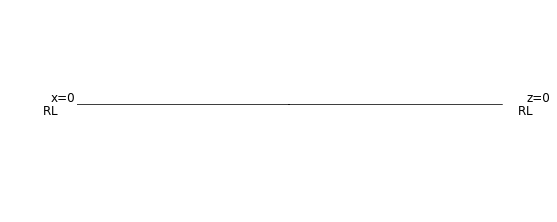

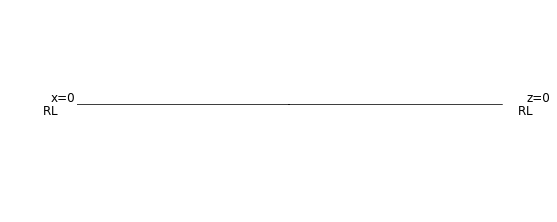

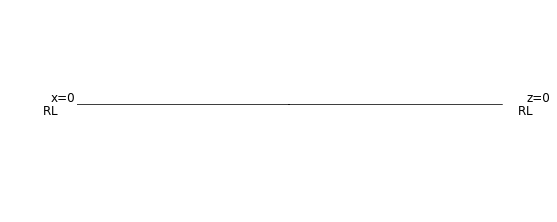

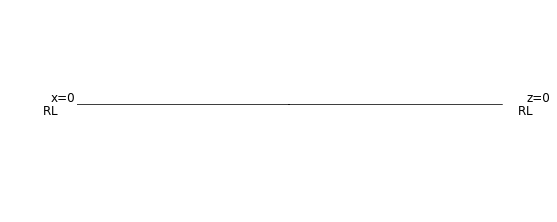

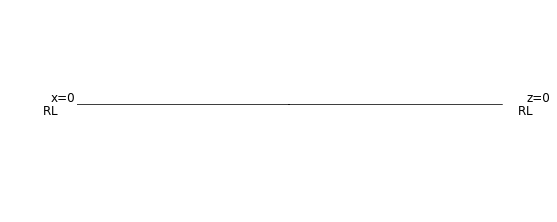

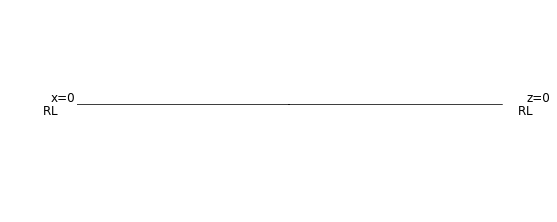

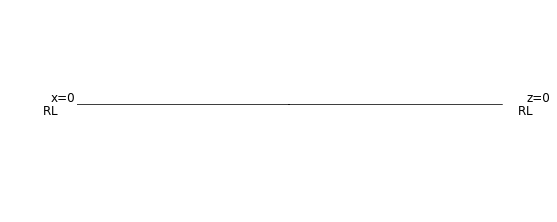

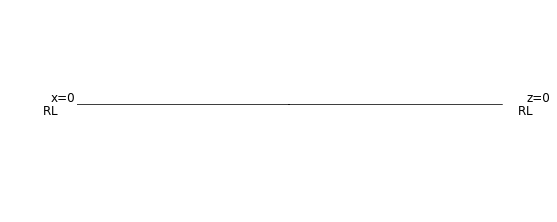

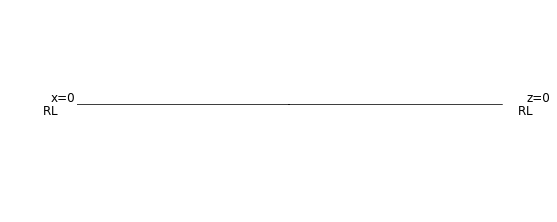

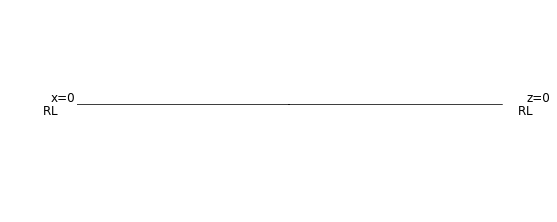

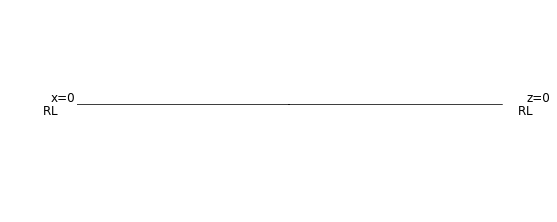

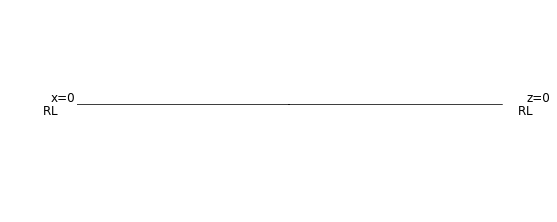

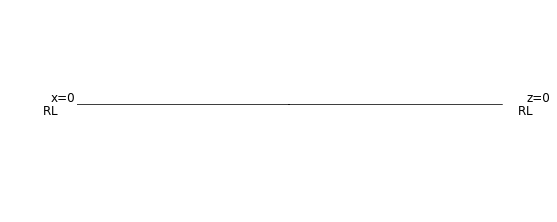

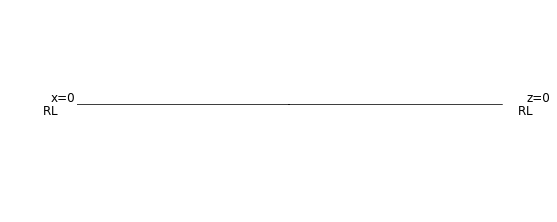

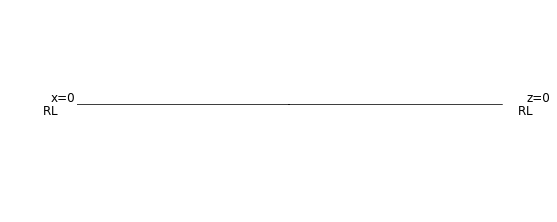

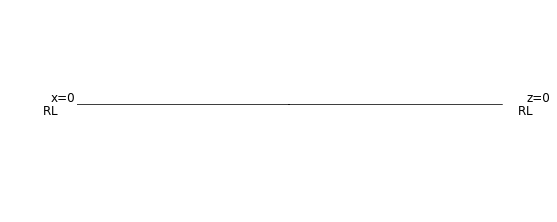

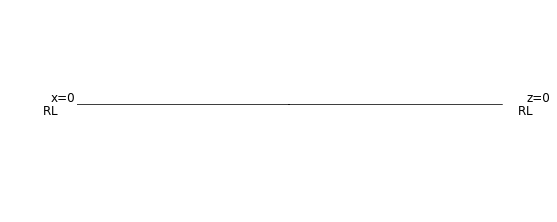

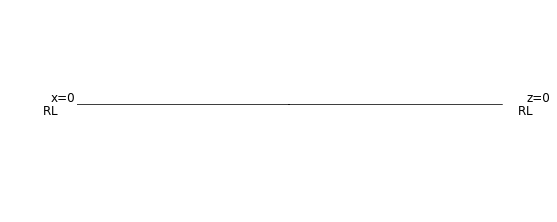

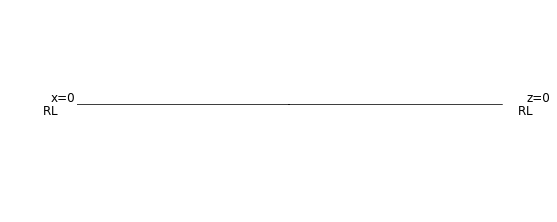

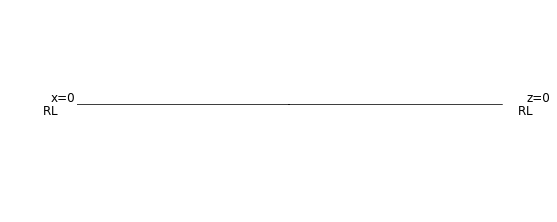

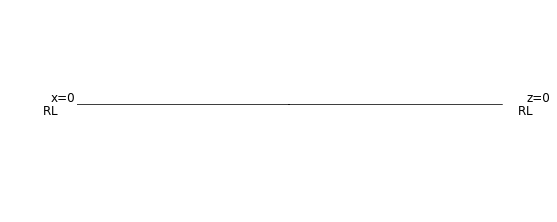

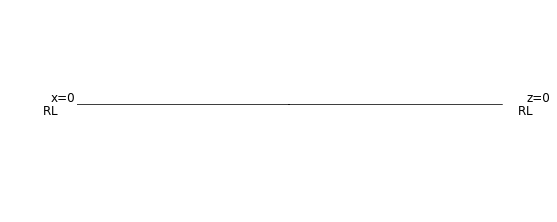

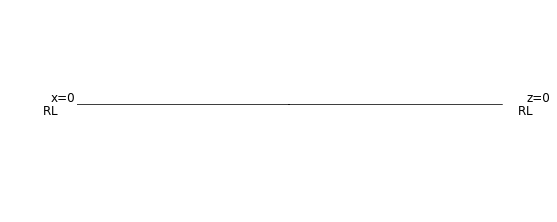

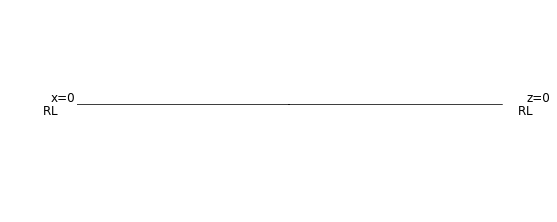

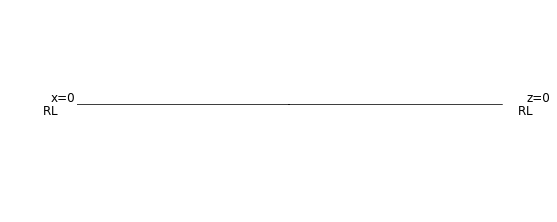

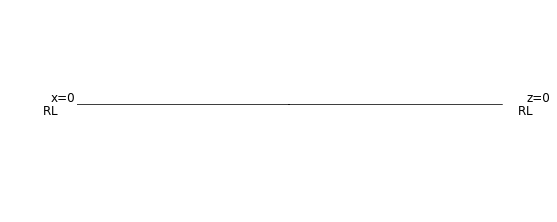

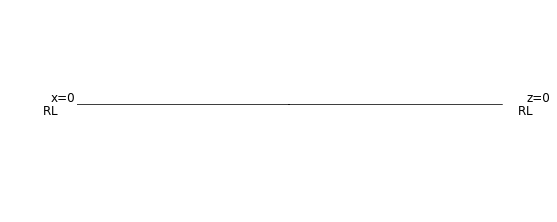

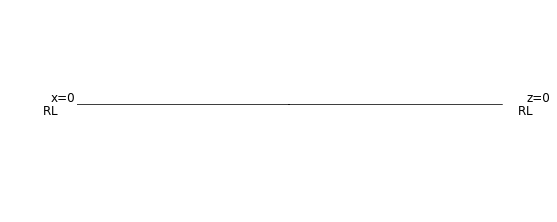

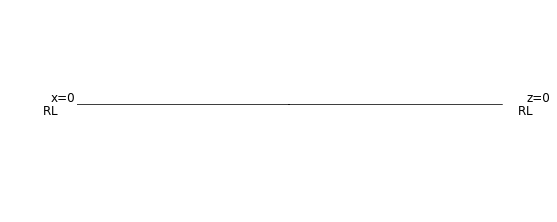

In [333]:
for i in range([0, 10, 2]):
    plotvol(cur_z[0, i])